In [4]:
import os
import time
import uuid
import cv2

In [10]:
IMAGES_PATH  = os.path.join('data','images')
number_images  = 10

In [14]:
# As of now, captured img from phone as there seems some issues with opencv and windows
# below code opens camera and saves images captured in data/image folder
# cap = cv2.VideoCapture(1)
# if cap.isOpened():
#     for imgnum in range(number_images):
#         print("Collecting image {}".format(imgnum))
#         ret, frame = cap.read()
#         imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#         cv2.imwrite(imgname,frame)
#         cv2.imshow('frame',frame)
#         time.sleep(5)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#         cap.release()
#         cv2.destroyAllWindows()


In [15]:
!labelme

2024-06-12 20:50:16,776 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Lenovo\.labelmerc


<h2>Review Dataset and Build image Loading Function</h2>

In [16]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt


In [20]:
# test gpu
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# tf.test.is_gpu_available()

In [21]:
images = tf.data.Dataset.list_files('data\\images\\*jpg',shuffle=True)

In [22]:
images.as_numpy_iterator().next()

b'data\\images\\IMG_20240612_202734.jpg'

In [23]:
def load_image(x):
    byte_img  = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_img)
    return image

In [24]:
images = images.map(load_image)

In [25]:
images.as_numpy_iterator().next()

array([[[216, 194, 171],
        [215, 193, 170],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [205, 199, 185],
        [205, 199, 185]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [206, 200, 186],
        [206, 200, 186]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [207, 201, 187],
        [206, 200, 186],
        [207, 201, 187]],

       ...,

       [[ 72,  70,  55],
        [ 72,  70,  55],
        [ 76,  74,  59],
        ...,
        [210, 210, 200],
        [210, 210, 200],
        [210, 210, 200]],

       [[ 75,  73,  58],
        [ 76,  74,  59],
        [ 77,  75,  60],
        ...,
        [210, 210, 200],
        [208, 208, 198],
        [208, 208, 198]],

       [[ 77,  75,  60],
        [ 78,  76,  61],
        [ 78,  76,  61],
        ...,
        [210, 210, 200],
        [207, 207, 197],
        [207, 207, 197]]

<h4>View raw images with matplotlib</h4>

In [26]:
image_generator = images.batch(4).as_numpy_iterator()

In [27]:
plot_images = image_generator.next()

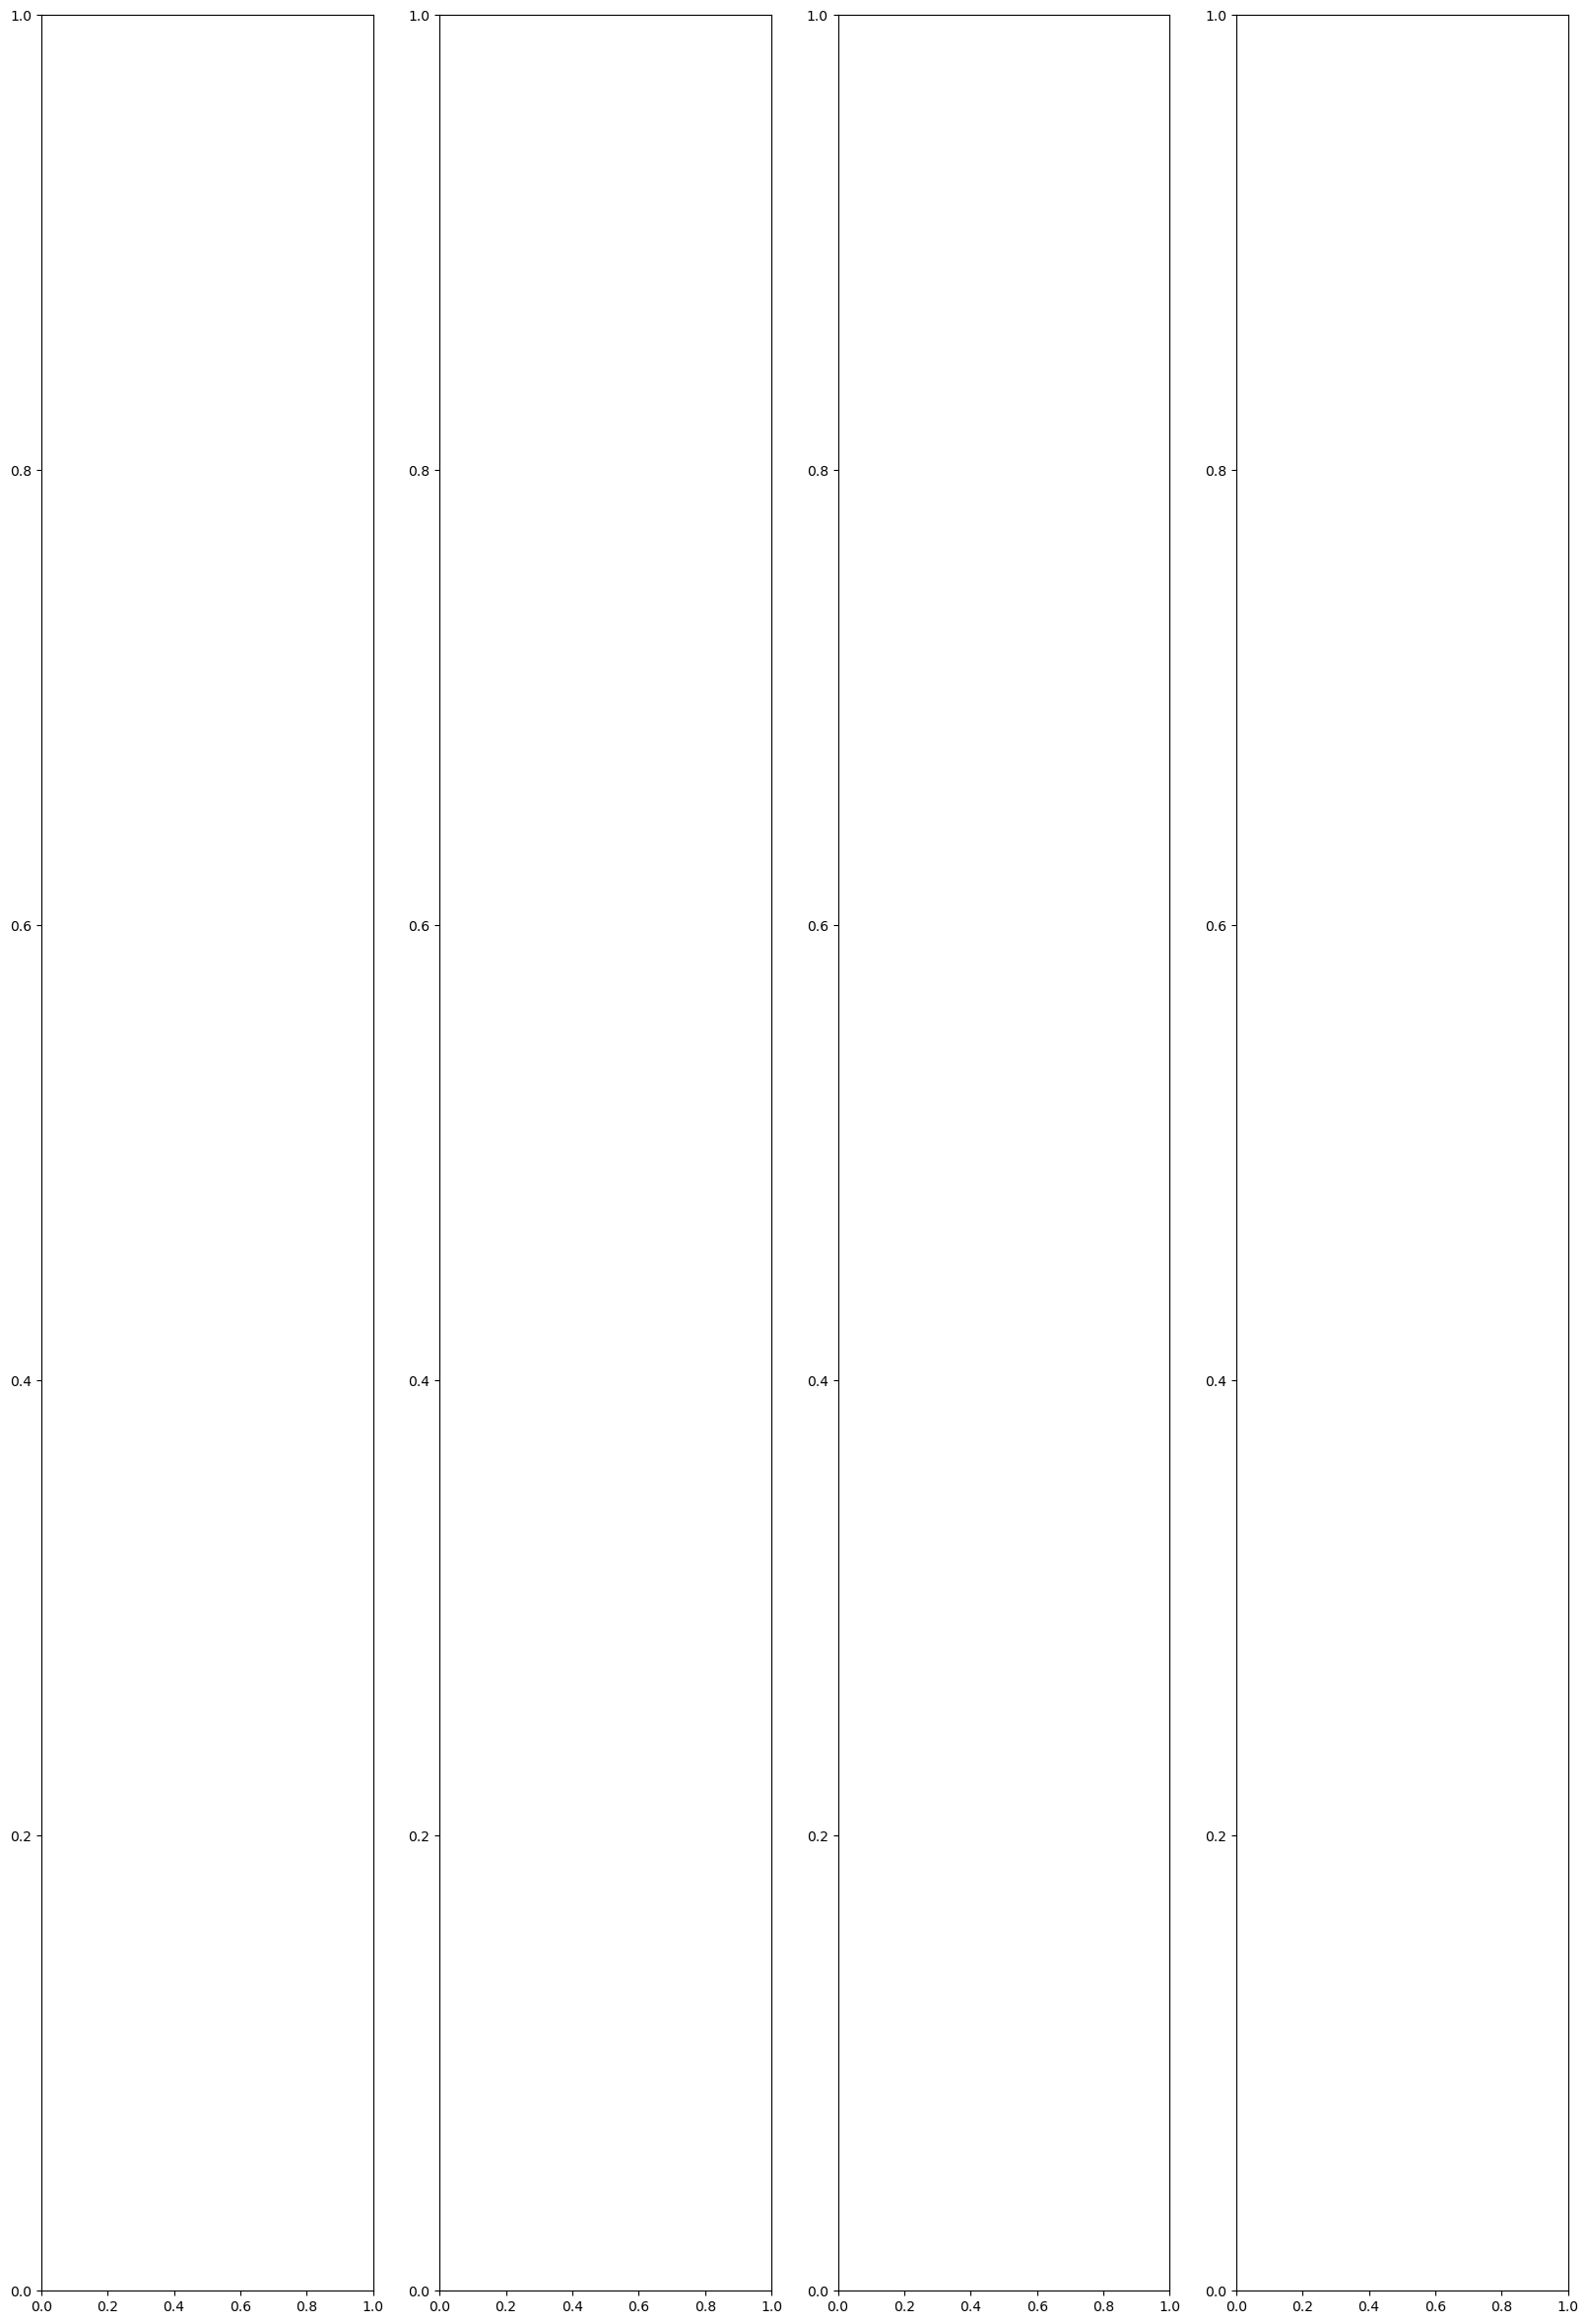

In [128]:
fig, ax = plt.subplots(ncols=4,figsize=(20,30))
for idx,image in enumerate(plot_images):
    pass
#     ax[idx].imshow(image)
# plt.show()

<h2>3. Partition Unaugmented Data</h2>

In [31]:
# manual partition
# 60-> train, 15 ->test, 15-> val


<h4>Move the Matching Labels</h4>
<h6>Due to this the labels gets moved to respective 3 folders created</h6>

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

<h2>4. Apply Image Augmentation on Images and Labels using Albumentations</h2>

<h4>4.A Setup Albumentations Transform Pipeline</h4>

In [33]:
import albumentations as alb

In [34]:
augmentor = alb.Compose([alb.RandomCrop(width=2000, height=2000), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

<h4>4.B Load a Test Image and Annotation with OpenCV and JSON</h4>

In [80]:
img = cv2.imread(os.path.join('data','train','images','IMG_20240612_202746.jpg'))

In [81]:
with open(os.path.join('data','train','labels','IMG_20240612_202746.json'),'r') as f:
    label = json.load(f)

In [82]:
label['shapes'][0]['points']

[[577.333333333333, 811.6666666666665],
 [2243.9999999999995, 2586.6666666666665]]

<h4>4.C Extract Coordinates and Rescale to Match Image Resolution</h4>

In [83]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [84]:
coords

[577.333333333333, 811.6666666666665, 2243.9999999999995, 2586.6666666666665]

In [85]:
# transform images for pascal_voc to albumentations format
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
IMAGE_DIMS = [3488,4640,3488,4640]
coords = list(np.divide(coords, IMAGE_DIMS))

In [86]:
coords


[0.1655198776758409, 0.1749281609195402, 0.6433486238532109, 0.557471264367816]

<h4>4.D Apply Augmentations and View Results</h4>

In [87]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [88]:
augmented['bboxes']

[(0.3505000000000002, 0.21033333333333326, 1.0, 1.0)]

In [91]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [2000,2000]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [2000,2000]).astype(int)), 
                    (255,0,0), 2)

#plt.imshow(augmented['image'])

array([[[201, 213, 215],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [200, 213, 227],
        [197, 210, 226],
        [190, 201, 221]],

       [[200, 212, 214],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [201, 214, 228],
        [198, 210, 228],
        [187, 200, 222]],

       [[199, 211, 213],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [201, 214, 228],
        [196, 208, 226],
        [185, 198, 220]],

       ...,

       [[154, 147, 144],
        [167, 162, 159],
        [185, 180, 177],
        ...,
        [ 52,  41,  37],
        [ 55,  44,  40],
        [255,   0,   0]],

       [[174, 167, 164],
        [192, 187, 184],
        [210, 205, 202],
        ...,
        [ 52,  41,  37],
        [ 55,  44,  40],
        [255,   0,   0]],

       [[188, 183, 182],
        [214, 209, 206],
        [231, 226, 223],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

<h2>5. Build and Run Augmentation Pipeline</h2>

<h4>5.A Run Augmentation Pipeline</h4>

In [95]:
# Here we will be storing augmented images in aug_data folder and doing annotations of these images
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, IMAGE_DIMS))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

<h4>5.B Load Augmented Images to Tensorflow Dataset</h4>

In [96]:
train_images = tf.data.Dataset.list_files("aug_data\\train\\images\\*.jpg",shuffle=False)
train_images = train_images.map(load_image)
# we are compressing more the images to make it of less size so our neural network can be more efficient
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

In [97]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [98]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [99]:
train_images.as_numpy_iterator().next()

array([[[0.2208061 , 0.21688454, 0.23649238],
        [0.19183007, 0.19183007, 0.1996732 ],
        [0.23529412, 0.23529412, 0.23638345],
        ...,
        [0.42222255, 0.42222255, 0.4300657 ],
        [0.38856265, 0.38464108, 0.37679794],
        [0.34771258, 0.34771258, 0.3464057 ]],

       [[0.18986928, 0.18594772, 0.20555556],
        [0.19313726, 0.19313726, 0.2009804 ],
        [0.21143788, 0.21143788, 0.21143788],
        ...,
        [0.42810392, 0.42810392, 0.43594706],
        [0.44509757, 0.42156816, 0.42156816],
        [0.36666715, 0.35098088, 0.3470593 ]],

       [[0.22091503, 0.21699347, 0.23660131],
        [0.2026144 , 0.2026144 , 0.21045753],
        [0.21241829, 0.21241829, 0.21241829],
        ...,
        [0.46209085, 0.4542477 , 0.46732026],
        [0.37483898, 0.33660328, 0.3225522 ],
        [0.43202406, 0.39956215, 0.38834214]],

       ...,

       [[0.1190626 , 0.13867043, 0.2171018 ],
        [0.10228774, 0.10947696, 0.1918299 ],
        [0.22952138, 0

<h2>6. Prepare Labels</h2>

<h4>6.A Build Label Loading Function</h4>

In [100]:
# Function returns the bbox and class in the labels json if a json file path is passed to it
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

<h4>6.B Load Labels to Tensorflow Dataset</h4>

In [102]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8, tf.float16]))

In [103]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [104]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [105]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2362, 0.    , 0.8696, 0.765 ], dtype=float16))

<h2>7. Combine Label and Image Samples</h2>

<h4>7A  Check Partition Lengths</h4>

In [106]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 900, 900, 900, 900)

<h4>7.B Create Final Datasets (Images/Labels)</h4>

In [107]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [108]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [109]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [111]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [112]:
# 0th index corresponds to each batch
# 8 is batch size, 120*120 is the dimension, 3 is rgb channel

In [113]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.    , 0.    , 0.53  , 0.3928],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2815, 0.4355, 1.    , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.516 , 0.626 , 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.3225, 0.5244, 1.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

In [115]:
# 1st index is the class and bbox coordinates for each batch(8 images here)

<h4>7.C View Images and Annotations</h4>

In [116]:
data_samples = train.as_numpy_iterator()

In [117]:
res = data_samples.next()

In [122]:
# Plot each batch of images
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4): 
#     sample_image = res[0][idx]
#     sample_coords = res[1][1][idx]
    
#     cv2.rectangle(sample_image, 
#                   tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                   tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
#                         (255,0,0), 2)

#     ax[idx].imshow(sample_image)



<h2>8. Build Deep Learning using the Functional API</h2>

<h4>8.A Import Layers and Base Network</h4>

In [123]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [124]:
# 8.B Download VGG16
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 161s 3us/step


In [126]:
# we will be using vvg16 for building our neural network
# vgg16 is used for image classfication model that uses CNN
# we are doing include_top= False as we will be discarding the final layer of vgg16 and 
# instead create our own custom final layer as per the requirement
# for this model, we have 2 outputs
# 1 is the class  or 1-> so for this we make classification output with sigmoid activation function
# 2nd is regression which maps to coordinates of bbox so for this also we use sigmoid activation function

In [127]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
# 8.C Build instance of Network
def build_model():
    input_layer = Input(shape=(120,120,3))
    #pass input layer to the vgg16 model
    vgg = VGG16(include_top=False)(input_layer)
    # Classification model
    f1= GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    # class2 is the output layer for the classification model. We are passing 1 as there is one o/p(0 or 1 class)
    class2 =Dense(1, activation='sigmoid')(class1)

    # Regression model for Bounding box coordinates
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(f2)
    # regress2 is the o/p layer for the Regression model. We are passing 4 here as there are 4 coordinates for bbox
    regress2 = Dense(4, activation='sigmoid')(regress1)

    # Combine both the layers
    facetracker = Model(inputs = input_layer, outputs = [class2,regress2])
    return facetracker

<h4>8.D Testing Neural Network</h4>

In [131]:
facetracker = build_model()

In [132]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
X,y = train.as_numpy_iterator().next()

In [134]:
X.shape

(8, 120, 120, 3)

In [135]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [136]:
print(classes)
print(coords)

[[0.5995504 ]
 [0.6239593 ]
 [0.6630492 ]
 [0.6393225 ]
 [0.58481264]
 [0.51232433]
 [0.61778903]
 [0.64139974]]
[[0.45977178 0.49015072 0.4337397  0.43028116]
 [0.4793832  0.63648486 0.45967185 0.5459441 ]
 [0.47615698 0.60776514 0.4467212  0.5014548 ]
 [0.48677418 0.52414227 0.29853314 0.52878284]
 [0.45086506 0.6032304  0.50020456 0.5149672 ]
 [0.5245378  0.50659454 0.4115237  0.40197116]
 [0.55053926 0.5105332  0.36616996 0.46115077]
 [0.4763552  0.6456634  0.39951542 0.43717852]]


<h2>9. Define Losses and Optimizers</h2>

<h4>9.A Define Optimizer and LR</h4>

In [137]:
# we will be gradually decreasing our learning rate dring training so as to reduce chances of overfitting & gradient overshoot
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [138]:
lr_decay

0.0007407407407407406

In [140]:
# creating optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

<h4>9.B Create Localization Loss and Classification Loss</h4>

In [141]:
# https://lilianweng.github.io/posts/2018-12-27-object-recognition-part-4/
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [142]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [ ]:
# 9.C Test out Loss Metrics
